[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/azad-academy/denoising-diffusion-model/blob/main/diffusion_model_demo.ipynb)

# Diffusion Models Tutorial

#### Author : J. Rafid Siddiqui (jrs@azaditech.com)


## Loading Data

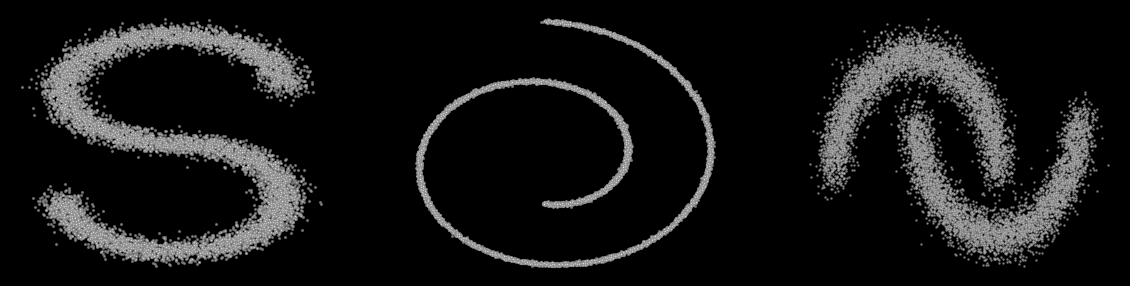

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_checkerboard,make_circles,make_moons,make_s_curve,make_swiss_roll
from helper_plot import hdr_plot_style
import torch
from utils import * 

hdr_plot_style()
swiss_roll, _ = make_swiss_roll(10**4,noise=0.1)
swiss_roll = swiss_roll[:, [0, 2]]/10.0

s_curve, _= make_s_curve(10**4, noise=0.1)
s_curve = s_curve[:, [0, 2]]/10.0

moons, _ = make_moons(10**4, noise=0.1)

data = s_curve.T
#dataset = torch.Tensor(data.T).float()


fig,axes = plt.subplots(1,3,figsize=(20,5))

axes[0].scatter(*data, alpha=0.5, color='white', edgecolor='gray', s=5);
axes[0].axis('off')

data = swiss_roll.T
axes[1].scatter(*data, alpha=0.5, color='white', edgecolor='gray', s=5);
axes[1].axis('off')
#dataset = torch.Tensor(data.T).float()

data = moons.T
axes[2].scatter(*data, alpha=0.5, color='white', edgecolor='gray', s=3);
axes[2].axis('off')
dataset = torch.Tensor(data.T).float()

## Diffusion Models

![diffusion-image](images/diffusion.png)

### Forward Diffusion

$$
q(\mathbf{x}_{t}\mid\mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_{t} ; \sqrt{1-\beta_{t}}\mathbf{x}_{t-1},\beta_{t}\mathbf{I})
$$

Substituting $\alpha_{t}=1-\beta_{t}$ and $\bar{\alpha}_{t} = \prod_{s=1}^{t} \alpha_{s}$: 

$$
q(\mathbf{x}_{t}\mid\mathbf{x}_{0}) = \mathcal{N}(\mathbf{x}_{t} ; \sqrt{\bar{\alpha}_{t}}\mathbf{x}_{t-1},(1-\bar{\alpha}_{t})\mathbf{I})
$$

Given the initial state, this makes it possible to draw sample at any desrired timestep without going through intermediate steps. Forward diffusion can also be written in terms of $x_0$ and the random noise $\epsilon \sim \mathcal{N}(0,1)$ [1]. This would be useful when performing denoising step later in the reverse diffusion.

$$
x_t(x_0,\epsilon) = \sqrt{\bar{\alpha}_{t}}\mathbf{x}_{0} + \sqrt{1-\bar{\alpha_{t}}}\epsilon          
$$

In [2]:
num_steps = 100
#betas = torch.tensor([1.7e-5] * num_steps)
betas = make_beta_schedule(schedule='sigmoid', n_timesteps=num_steps, start=1e-5, end=0.5e-2)

alphas = 1 - betas
alphas_prod = torch.cumprod(alphas, 0)
alphas_prod_p = torch.cat([torch.tensor([1]).float(), alphas_prod[:-1]], 0)
alphas_bar_sqrt = torch.sqrt(alphas_prod)
one_minus_alphas_bar_log = torch.log(1 - alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod)

In [3]:
def q_x(x_0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_0)
    alphas_t = extract(alphas_bar_sqrt, t, x_0)
    alphas_1_m_t = extract(one_minus_alphas_bar_sqrt, t, x_0)
    return (alphas_t * x_0 + alphas_1_m_t * noise)

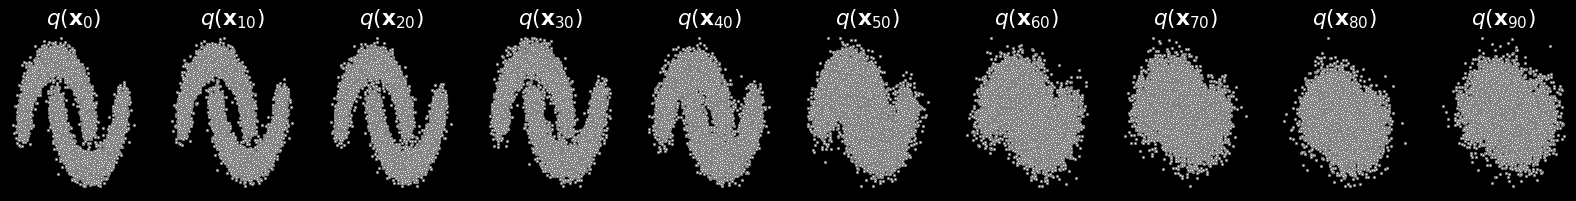

In [4]:
fig, axs = plt.subplots(1, 10, figsize=(28, 3))
for i in range(10):
    q_i = q_x(dataset, torch.tensor([i * 10]))
    axs[i].scatter(q_i[:, 0], q_i[:, 1],color='white',edgecolor='gray', s=5);
    axs[i].set_axis_off(); axs[i].set_title('$q(\mathbf{x}_{'+str(i*10)+'})$')

In [186]:
posterior_mean_coef_1 = (betas * torch.sqrt(alphas_prod_p) / (1 - alphas_prod))
posterior_mean_coef_2 = ((1 - alphas_prod_p) * torch.sqrt(alphas) / (1 - alphas_prod))
posterior_variance = betas * (1 - alphas_prod_p) / (1 - alphas_prod)
posterior_log_variance_clipped = torch.log(torch.cat((posterior_variance[1].view(1, 1), posterior_variance[1:].view(-1, 1)), 0)).view(-1)

def q_posterior_mean_variance(x_0, x_t, t):
    coef_1 = extract(posterior_mean_coef_1, t, x_0)
    coef_2 = extract(posterior_mean_coef_2, t, x_0)
    mean = coef_1 * x_0 + coef_2 * x_t
    var = extract(posterior_log_variance_clipped, t, x_0)
    return mean, var

## Reverse Diffusion/Reconstruction

Unlike the forward diffusion, the reverse diffusion process requires training of a neural network model. We setup the necessary loss functions and training parameters and then perform the training.

## Training

### Training Loss

The original loss was proposed in Sohl-Dickstein et al. [1] as following:

\begin{align}
K = -\mathbb{E}_{q}[ &D_{KL}(q(\mathbf{x}_{t-1}\mid\mathbf{x}_{t},\mathbf{x}_{0}) \Vert p_{\theta}(\mathbf{x}_{t-1}\mid\mathbf{x}_{t}))  \\
&+ H_{q}(\mathbf{X}_{T}\vert\mathbf{X}_{0}) - H_{q}(\mathbf{X}_{1}\vert\mathbf{X}_{0}) - H_{p}(\mathbf{X}_{T})]
\end{align} 


In order to improve the results, the authors in Ho et al. [2] proposed multiple improvements. Following Parameterization of mean is proposed: 

$$
\mathbf{\mu}_{\theta}(\mathbf{x}_{t}, t) = \frac{1}{\sqrt{\alpha_{t}}} \left( (\mathbf{x}_{t} - \frac{\beta_{t}}{\sqrt{1 - \bar{\alpha}}_{t}} \mathbf{\epsilon}_{\theta} (\mathbf{x}_{t}, t) \right) 
$$

further, variance is taken as constant and the step for reverse diffusion then becomes:

$$
\mathbf{x}_{t-1} = \frac{1}{\sqrt{\alpha_{t}}} \left( \mathbf{x}_{t} - \frac{1-\alpha_{t}}{\sqrt{1-\bar{\alpha_{t}}}} \mathbf{\epsilon}_{\theta}(\mathbf{x}_{t}, t) \right) + \sigma_{t}\mathbf{z}
$$



After further improvements and simplifications the loss function becomes:

$$
\mathcal{L}_{\text{simple}}=\mathbb{E}_{t, \mathbf{x}_{0},\mathbf{\epsilon}}\left[ \Vert \epsilon - \epsilon_{\theta}(\sqrt{\bar{\alpha}_{t}}\mathbf{x}_{0} + \sqrt{1 - \bar{\alpha}_{t}}\mathbf{\epsilon}, t) \Vert^{2} \right].
$$

tensor(0.9015, grad_fn=<MeanBackward0>)
tensor(1.0045, grad_fn=<MeanBackward0>)
tensor(0.8242, grad_fn=<MeanBackward0>)
tensor(0.6746, grad_fn=<MeanBackward0>)
tensor(0.9416, grad_fn=<MeanBackward0>)
tensor(1.1814, grad_fn=<MeanBackward0>)
tensor(0.3878, grad_fn=<MeanBackward0>)
tensor(0.3528, grad_fn=<MeanBackward0>)
tensor(0.8843, grad_fn=<MeanBackward0>)
tensor(0.8321, grad_fn=<MeanBackward0>)


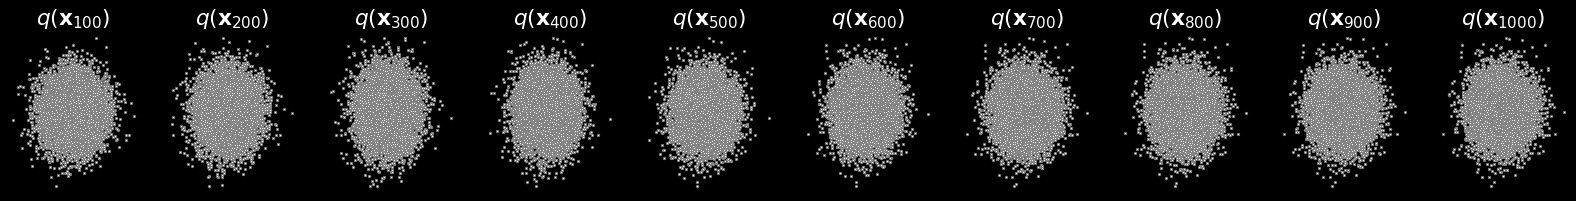

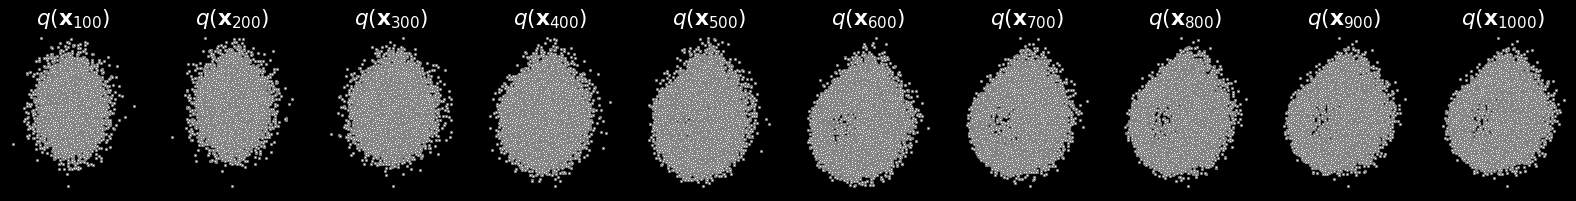

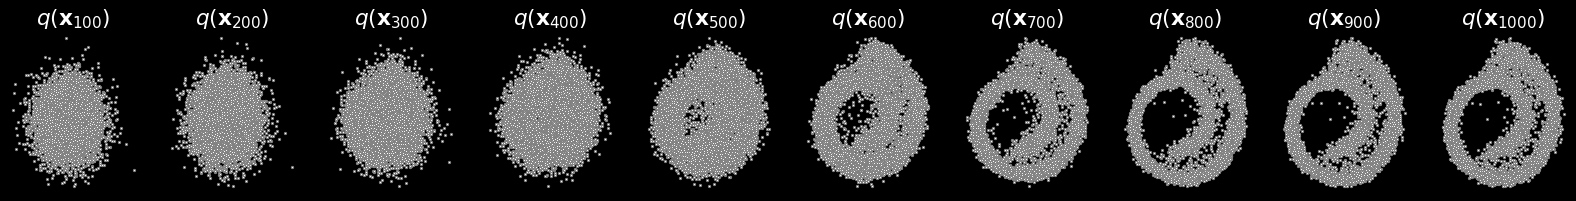

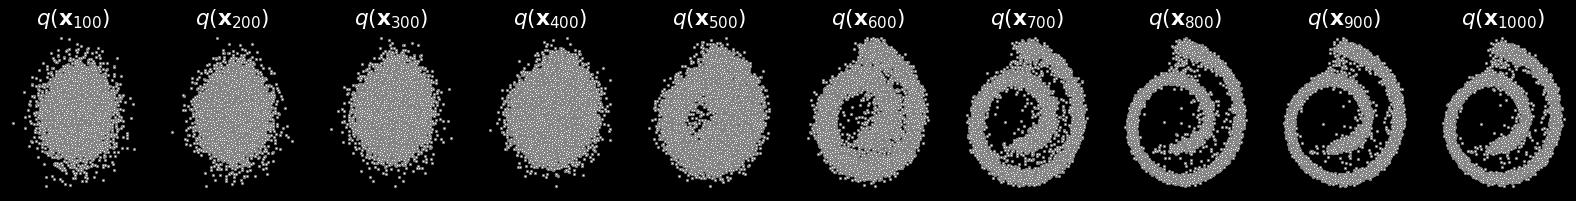

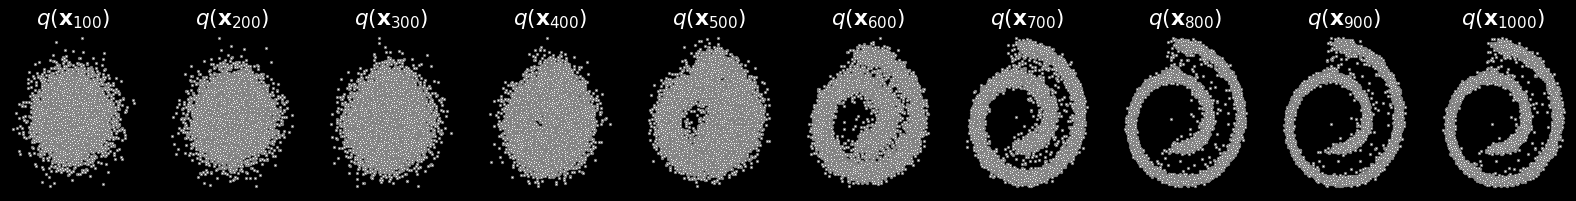

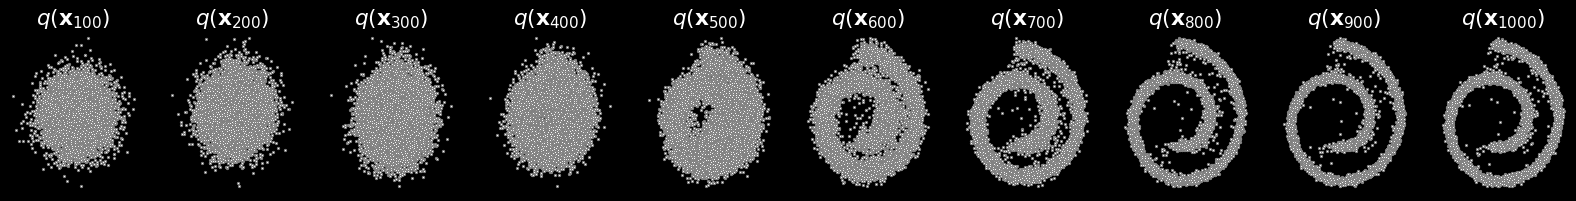

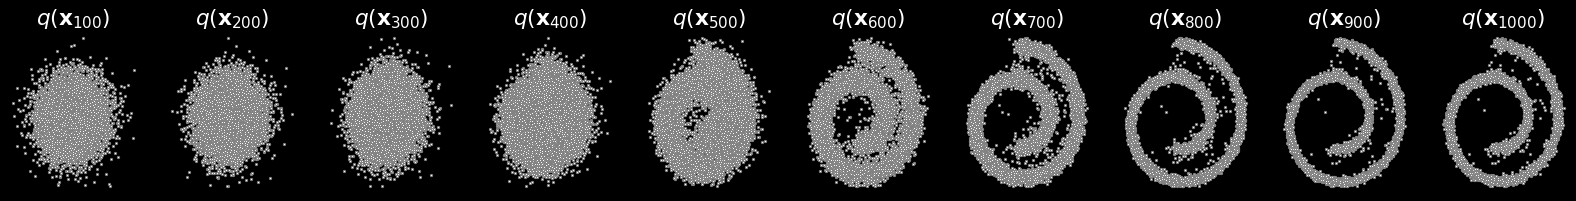

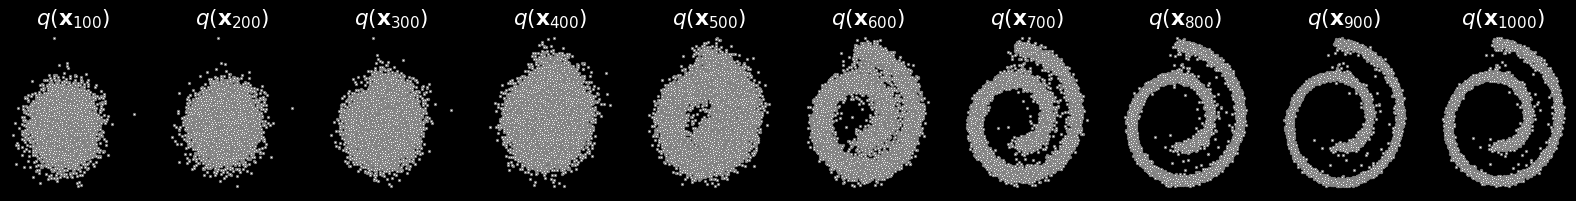

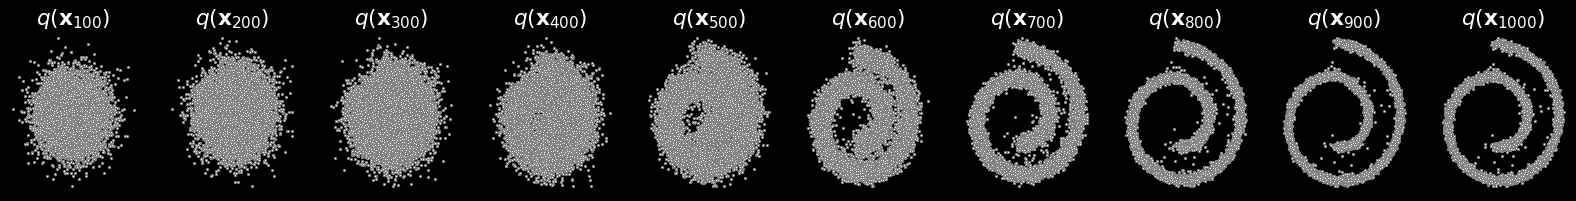

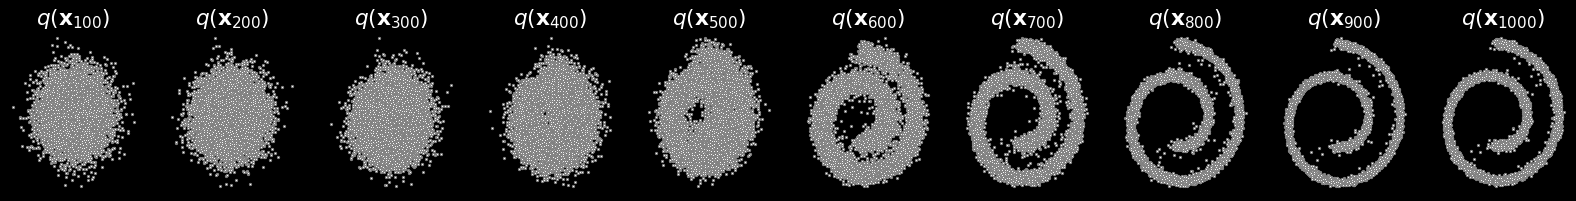

In [187]:
from model import ConditionalModel
from ema import EMA
import torch.optim as optim

model = ConditionalModel(num_steps)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
#dataset = torch.tensor(data.T).float()
# Create EMA model
ema = EMA(0.9)
ema.register(model)
# Batch size
batch_size = 128
for t in range(1000):
    # X is a torch Variable
    permutation = torch.randperm(dataset.size()[0])
    for i in range(0, dataset.size()[0], batch_size):
        # Retrieve current batch
        indices = permutation[i:i+batch_size]
        batch_x = dataset[indices]
        # Compute the loss.
        loss = noise_estimation_loss(model, batch_x,alphas_bar_sqrt,one_minus_alphas_bar_sqrt,num_steps)
        # Before the backward pass, zero all of the network gradients
        optimizer.zero_grad()
        # Backward pass: compute gradient of the loss with respect to parameters
        loss.backward()
        # Perform gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        # Calling the step function to update the parameters
        optimizer.step()
        # Update the exponential moving average
        ema.update(model)
    # Print loss
    if (t % 100 == 0):
        print(loss)
        x_seq = p_sample_loop(model, dataset.shape,num_steps,alphas,betas,one_minus_alphas_bar_sqrt)
        fig, axs = plt.subplots(1, 10, figsize=(28, 3))
        for i in range(1, 11):
            cur_x = x_seq[i * 10].detach()
            axs[i-1].scatter(cur_x[:, 0], cur_x[:, 1],color='white',edgecolor='gray', s=5);
            axs[i-1].set_axis_off(); 
            axs[i-1].set_title('$q(\mathbf{x}_{'+str(i*100)+'})$')

## Animation

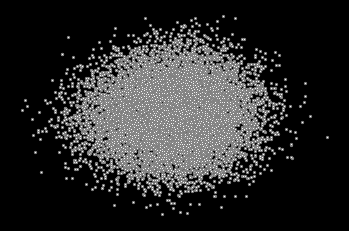

In [188]:
# Generating the forward image sequence

import io
from PIL import Image

imgs = []
#fig, axs = plt.subplots(1, 10, figsize=(28, 3))
for i in range(100):
    plt.clf()
    q_i = q_x(dataset, torch.tensor([i]))
    plt.scatter(q_i[:, 0], q_i[:, 1],color='white',edgecolor='gray', s=5);
    plt.axis('off'); 
    
    img_buf = io.BytesIO()
    plt.savefig(img_buf, format='png')
    img = Image.open(img_buf)
    imgs.append(img)
    

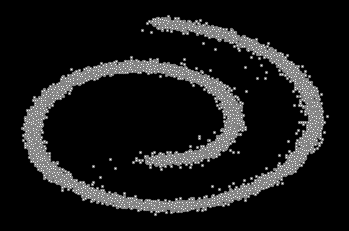

In [189]:
# Generating the reverse diffusion sequence

reverse = []
for i in range(100):  
    plt.clf()
    cur_x = x_seq[i].detach()
    plt.scatter(cur_x[:, 0], cur_x[:, 1],color='white',edgecolor='gray', s=5);
    plt.axis('off')
    
    img_buf = io.BytesIO()
    plt.savefig(img_buf, format='png')
    img = Image.open(img_buf)
    reverse.append(img)

In [190]:
imgs = imgs + reverse

In [191]:
imgs[0].save("diffusion.gif", format='GIF', append_images=imgs,save_all=True, duration=100, loop=0)

# References

[1] Ho, J., Jain, A., & Abbeel, P. (2020). Denoising diffusion probabilistic models. arXiv preprint arXiv:2006.11239.

[2] Sohl-Dickstein, J., Weiss, E. A., Maheswaranathan, N., & Ganguli, S. (2015). Deep unsupervised learning using nonequilibrium thermodynamics. arXiv preprint arXiv:1503.03585.